In [1]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# https://medium.com/@kurtsenol21/topic-modeling-lda-mallet-implementation-in-python-part-1-c493a5297ad2
# https://jeriwieringa.com/projects/dissertation/
# https://radimrehurek.com/gensim/models/wrappers/ldamallet.html

# http://journalofdigitalhumanities.org/2-1/words-alone-by-benjamin-m-schmidt/
# https://mimno.infosci.cornell.edu/topics.html
# https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/

# Packages

import os
import pandas as pd
import json
from datetime import datetime as dt
import re
from itertools import compress
from itertools import chain
import ast
import spacy
import numpy as np

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(20,12)})

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

nlp = spacy.load("da_core_news_sm", disable=['parser', 'ner'])

In [58]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
data_path = os.path.join('/work', 'dl2020_horesta-scraper', 'data')
datawork_path = os.path.join('/work', 'dl2020_horesta-scraper', 'data', 'work')
out_path = os.path.join('/work', 'dl2020_horesta-scraper', 'output')

filename_in = 'horesta_posts_2021-03-25_tokenized.json'

In [3]:
# Loading data
path = os.path.join(datawork_path, filename_in)

with open(path, 'r') as file:
    data = json.load(file)
    
len(data)

1351

In [4]:
# Corpus objects

id2token = corpora.Dictionary([entry.get('tokens') for entry in data])

tokens_bow = [entry.get('doc2bow') for entry in data]
tokens_tfidf = [entry.get('tfidfbow') for entry in data]
corpus_texts = [entry.get('tokens') for entry in data]

In [11]:
# Read in results from tuning

filename = "coherence_parameter-tuning.jsonl"

with open(os.path.join(out_path, filename), 'r', encoding = 'utf-8') as f:
    parameters = [json.loads(jline) for jline in f]

In [10]:
# Set up model 

n_topics = 7
chunksize = 2000
passes = 20
iterations = 500

lda_model = gensim.models.LdaModel(corpus = tokens_tfidf, 
                                   num_topics = n_topics, 
                                   id2word = id2token, 
                                   chunksize = chunksize, 
                                   passes = passes, 
                                   iterations = iterations, 
                                   random_state = 1332,
                                   eval_every = 10,
                                   alpha = "auto",
                                   eta = "auto")

In [11]:
coherence_model_lda = CoherenceModel(model=lda_model, corpus=tokens_tfidf, coherence='u_mass')
print(coherence_model_lda.get_coherence())

-2.240274026799423


In [12]:
data[0].get('title')

'Det er tid til at få det lange lys på'

In [13]:
lda_model[tokens_tfidf[0]]

[(0, 0.9604568)]

In [14]:
from pprint import pprint 

# Show Topics
pprint(lda_model.show_topics(formatted=False, num_topics=n_topics))

[(0,
  [('politisk', 0.0015934637),
   ('erhverv', 0.0015237186),
   ('restriktion', 0.0014929214),
   ('regering', 0.0014206679),
   ('overnatning', 0.0013744553),
   ('virksomhed', 0.0013708771),
   ('hotel', 0.0013550682),
   ('arbejdskraft', 0.0012301144),
   ('mulighed', 0.0011939993),
   ('udlejning', 0.0011835756)]),
 (1,
  [('hotel', 0.0011468534),
   ('medarbejder', 0.0010656614),
   ('arbejde', 0.00084365177),
   ('virksomhed', 0.0008364219),
   ('sommertid', 0.0007556945),
   ('marts', 0.0007365685),
   ('udvikling', 0.0007331495),
   ('dansk', 0.00071188883),
   ('juridisk', 0.00070080155),
   ('vintertid', 0.00069277483)]),
 (2,
  [('årets', 0.0013249352),
   ('dansk', 0.0010877756),
   ('virksomhed', 0.0010234236),
   ('overnatning', 0.0009992599),
   ('tilmelding', 0.0009781506),
   ('hotel', 0.0008830242),
   ('måned', 0.00087208586),
   ('medarbejder', 0.0008635543),
   ('direktør', 0.00085776363),
   ('fortælle', 0.0008567352)]),
 (3,
  [('kampagne', 0.0010412481),
  

In [15]:
# Add topic probabilities to data

for entry in data:
    entry['lda'] = lda_model[entry.get('tfidfbow')]

In [16]:
# Filter out variables

data_select = []
keys_select = ['url', 'accessed', 'title', 'tags', 'publish_date', 'access_date', 'text', 'tokens', 'lda']

for entry in data:
    entry_filtered = dict()
    for k,v in entry.items():
        if k in keys_select:
            entry_filtered[k] = v
    
    data_select.append(entry_filtered)

In [17]:
# Converting data to data frame

df = pd.DataFrame.from_records(data_select)

In [18]:
df.head()

,url,accessed,title,tags,publish_date,access_date,text,tokens,lda
0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","[(0, 0.96045685)]"
1,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDer er akut behov for at få st...,"[behov, styrke, oplevelsesøkonomiens, konkurre...","[(5, 0.5377074), (6, 0.42610568)]"
2,https://horesta.dk/nyheder/2020/december/hores...,1,HORESTA: Feriepenge bør følges op med et oplev...,"[feriepenge, hjælpepakker, turisme, dansk turi...",03-12 - 2020,2020-12-04,"\n\n\n\n\n\n\n\nHORESTA tager positivt imod, a...","[positiv, flertal, parat, frigive, sidste, ind...","[(6, 0.95956933)]"
3,https://horesta.dk/nyheder/2020/december/webin...,1,Webinar med Danske Bank: Her bruger danskerne ...,"[webinar, forbrug, danske bank, louise aggerst...",03-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDanskernes forbrugsvaner har æ...,"[danskernes, forbrugsvane, ændre, coronakrisen...","[(0, 0.010670613), (4, 0.9409042), (6, 0.01216..."
4,https://horesta.dk/nyheder/2020/december/sidst...,1,Sidste chance for finansiering – hør mere på w...,"[vækstfonden, finansiering, coronakrise]",02-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nHORESTA inviterer til webinar ...,"[horesta, invitere, webinar, tirsdag, december...","[(0, 0.93142265), (2, 0.010500613), (4, 0.0135..."


In [19]:
# Spreading topics across rows

df_topiclong = df.explode('lda').reset_index(drop = True)
df_topiclong.head()

,url,accessed,title,tags,publish_date,access_date,text,tokens,lda
0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(0, 0.96045685)"
1,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDer er akut behov for at få st...,"[behov, styrke, oplevelsesøkonomiens, konkurre...","(5, 0.5377074)"
2,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDer er akut behov for at få st...,"[behov, styrke, oplevelsesøkonomiens, konkurre...","(6, 0.42610568)"
3,https://horesta.dk/nyheder/2020/december/hores...,1,HORESTA: Feriepenge bør følges op med et oplev...,"[feriepenge, hjælpepakker, turisme, dansk turi...",03-12 - 2020,2020-12-04,"\n\n\n\n\n\n\n\nHORESTA tager positivt imod, a...","[positiv, flertal, parat, frigive, sidste, ind...","(6, 0.95956933)"
4,https://horesta.dk/nyheder/2020/december/webin...,1,Webinar med Danske Bank: Her bruger danskerne ...,"[webinar, forbrug, danske bank, louise aggerst...",03-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDanskernes forbrugsvaner har æ...,"[danskernes, forbrugsvane, ændre, coronakrisen...","(0, 0.010670613)"


In [20]:
# Splitting topic and probabilities into columns

df_topiclong = df_topiclong.assign(**pd.DataFrame(df_topiclong['lda'].tolist(), columns = ['topic', 'topic_prob']))

In [21]:
df_topiclong.head(10)

,url,accessed,title,tags,publish_date,access_date,text,tokens,lda,topic,topic_prob
0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(0, 0.96045685)",0,0.960457
1,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDer er akut behov for at få st...,"[behov, styrke, oplevelsesøkonomiens, konkurre...","(5, 0.5377074)",5,0.537707
2,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",04-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDer er akut behov for at få st...,"[behov, styrke, oplevelsesøkonomiens, konkurre...","(6, 0.42610568)",6,0.426106
3,https://horesta.dk/nyheder/2020/december/hores...,1,HORESTA: Feriepenge bør følges op med et oplev...,"[feriepenge, hjælpepakker, turisme, dansk turi...",03-12 - 2020,2020-12-04,"\n\n\n\n\n\n\n\nHORESTA tager positivt imod, a...","[positiv, flertal, parat, frigive, sidste, ind...","(6, 0.95956933)",6,0.959569
4,https://horesta.dk/nyheder/2020/december/webin...,1,Webinar med Danske Bank: Her bruger danskerne ...,"[webinar, forbrug, danske bank, louise aggerst...",03-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDanskernes forbrugsvaner har æ...,"[danskernes, forbrugsvane, ændre, coronakrisen...","(0, 0.010670613)",0,0.010671
5,https://horesta.dk/nyheder/2020/december/webin...,1,Webinar med Danske Bank: Her bruger danskerne ...,"[webinar, forbrug, danske bank, louise aggerst...",03-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDanskernes forbrugsvaner har æ...,"[danskernes, forbrugsvane, ændre, coronakrisen...","(4, 0.9409042)",4,0.940904
6,https://horesta.dk/nyheder/2020/december/webin...,1,Webinar med Danske Bank: Her bruger danskerne ...,"[webinar, forbrug, danske bank, louise aggerst...",03-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nDanskernes forbrugsvaner har æ...,"[danskernes, forbrugsvane, ændre, coronakrisen...","(6, 0.012164474)",6,0.012164
7,https://horesta.dk/nyheder/2020/december/sidst...,1,Sidste chance for finansiering – hør mere på w...,"[vækstfonden, finansiering, coronakrise]",02-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nHORESTA inviterer til webinar ...,"[horesta, invitere, webinar, tirsdag, december...","(0, 0.93142265)",0,0.931423
8,https://horesta.dk/nyheder/2020/december/sidst...,1,Sidste chance for finansiering – hør mere på w...,"[vækstfonden, finansiering, coronakrise]",02-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nHORESTA inviterer til webinar ...,"[horesta, invitere, webinar, tirsdag, december...","(2, 0.010500613)",2,0.010501
9,https://horesta.dk/nyheder/2020/december/sidst...,1,Sidste chance for finansiering – hør mere på w...,"[vækstfonden, finansiering, coronakrise]",02-12 - 2020,2020-12-04,\n\n\n\n\n\n\n\nHORESTA inviterer til webinar ...,"[horesta, invitere, webinar, tirsdag, december...","(4, 0.013546565)",4,0.013547


In [22]:
# Mean topic probability across data

df_topiclong.groupby('topic')['topic_prob'].mean()

topic
0    0.524111
1    0.575733
2    0.561205
3    0.556079
4    0.406033
5    0.550171
6    0.436229
Name: topic_prob, dtype: float64

In [23]:
# Date variables

df_topiclong['publish_date'] = pd.to_datetime(df_topiclong['publish_date'], format = '%d-%m - %Y')

df_topiclong['post_month'] = df_topiclong['publish_date'].dt.month
df_topiclong['post_year'] = df_topiclong['publish_date'].dt.year
df_topiclong['year_month'] = df_topiclong['publish_date'].apply(lambda x: str(x)[0:7])

In [24]:
# Topics over time

df_topictime_grouped = df_topiclong.groupby(['year_month', 'topic'])
df_topictime = df_topictime_grouped['topic_prob'].mean().to_frame(name = 'mean_top_prob').reset_index() # Counting
df_topictime['topic'] = df_topictime['topic'].astype('category')

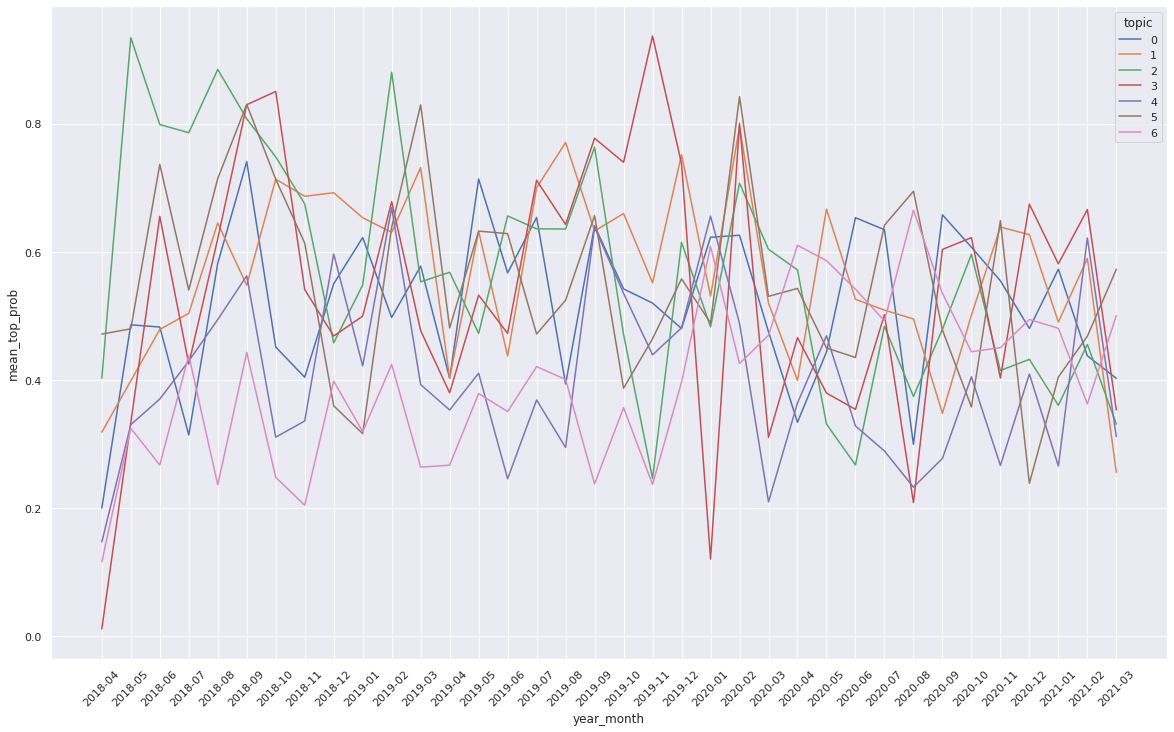

In [25]:
# Visualize topics over time

#viz_set = df_topictime.loc[df_topictime['topic'].isin([5, 13, 0]), :]
viz_set = df_topictime

sns.lineplot(data = viz_set, x = 'year_month', y = 'mean_top_prob', hue = 'topic')
plt.xticks(rotation = 45)
plt.show()

In [26]:
# Dominant topic

idx = df_topiclong.groupby(['url'])['topic_prob'].transform('max') == df_topiclong['topic_prob']

#df_topiclong.groupby(['url'])['topic_prob'].transform('max')
df_domtop = df_topiclong[idx]

df_domtop.head()

,url,accessed,title,tags,publish_date,access_date,text,tokens,lda,topic,topic_prob,post_month,post_year,year_month
0,https://horesta.dk/nyheder/2020/december/det-e...,1,Det er tid til at få det lange lys på,"[coronakrise, horesta, kirsten munch, vaccinat...",2020-12-04,2020-12-04,\n\n\n\n\n\n\n\nFra næste måned begynder udrul...,"[måned, begynde, udrulning, statslig, vaccinat...","(0, 0.96045685)",0,0.960457,12,2020,2020-12
1,https://horesta.dk/nyheder/2020/december/forsl...,1,Forslag om lavere moms,"[small danish hotels, jørgen christensen, moms...",2020-12-04,2020-12-04,\n\n\n\n\n\n\n\nDer er akut behov for at få st...,"[behov, styrke, oplevelsesøkonomiens, konkurre...","(5, 0.5377074)",5,0.537707,12,2020,2020-12
3,https://horesta.dk/nyheder/2020/december/hores...,1,HORESTA: Feriepenge bør følges op med et oplev...,"[feriepenge, hjælpepakker, turisme, dansk turi...",2020-12-03,2020-12-04,"\n\n\n\n\n\n\n\nHORESTA tager positivt imod, a...","[positiv, flertal, parat, frigive, sidste, ind...","(6, 0.95956933)",6,0.959569,12,2020,2020-12
5,https://horesta.dk/nyheder/2020/december/webin...,1,Webinar med Danske Bank: Her bruger danskerne ...,"[webinar, forbrug, danske bank, louise aggerst...",2020-12-03,2020-12-04,\n\n\n\n\n\n\n\nDanskernes forbrugsvaner har æ...,"[danskernes, forbrugsvane, ændre, coronakrisen...","(4, 0.9409042)",4,0.940904,12,2020,2020-12
7,https://horesta.dk/nyheder/2020/december/sidst...,1,Sidste chance for finansiering – hør mere på w...,"[vækstfonden, finansiering, coronakrise]",2020-12-02,2020-12-04,\n\n\n\n\n\n\n\nHORESTA inviterer til webinar ...,"[horesta, invitere, webinar, tirsdag, december...","(0, 0.93142265)",0,0.931423,12,2020,2020-12


In [27]:
# Topics over time

df_topictime_grouped = df_domtop.groupby(['year_month', 'topic'])
df_topictime = df_topictime_grouped['topic_prob'].mean().to_frame(name = 'mean_top_prob').reset_index() # Counting
df_topictime['topic'] = df_topictime['topic'].astype('category')

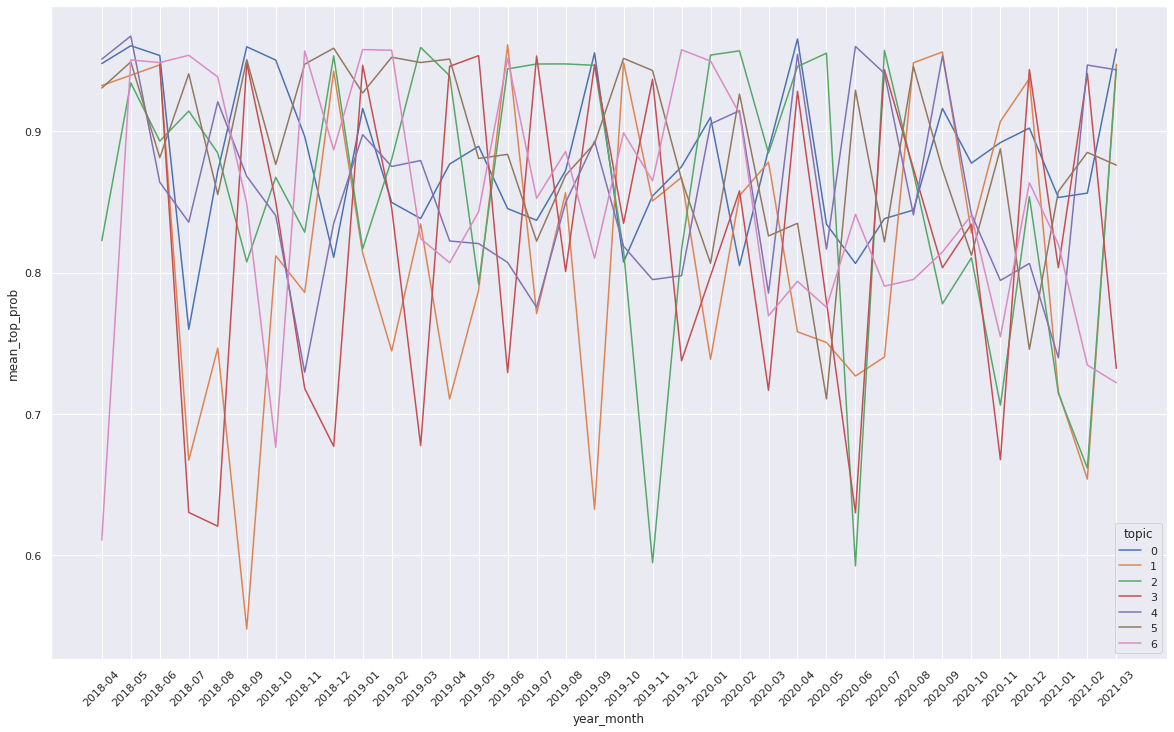

In [28]:
# Visualize topics over time

#viz_set = df_topictime.loc[df_topictime['topic'].isin([5, 13, 0]), :]
viz_set = df_topictime

sns.lineplot(data = viz_set, x = 'year_month', y = 'mean_top_prob', hue = 'topic')
plt.xticks(rotation = 45)
plt.show()

In [55]:
[word for word, prop in lda_model.show_topic(2, topn = 50)]

['årets',
 'dansk',
 'virksomhed',
 'overnatning',
 'tilmelding',
 'hotel',
 'måned',
 'medarbejder',
 'direktør',
 'fortælle',
 'vækst',
 'mangen',
 'konkurrence',
 'mulighed',
 'udenlandsk',
 'finde',
 'samle',
 'branche',
 'spørgsmål',
 'fødevarechef',
 'ferielov',
 'komme',
 'restaurant',
 'email',
 'antal',
 'protected',
 'information',
 'marts',
 'kontaktkort',
 'megen',
 'medlem',
 'kontakt',
 'yderlig',
 'erhverv',
 'svare',
 'region',
 'pulje',
 'politisk',
 'aftale',
 'periode',
 'samtidig',
 'særlig',
 'arbejde',
 'historie',
 'januar',
 'lokale',
 'fortsætte',
 'fokus',
 'følge',
 'kampagne']

### Exporting docs in topics

Exporting top 10 docs within each topic.

In [43]:
topdocs = df_domtop.sort_values('topic_prob', ascending = False).groupby(['topic']).head(10).sort_values(['topic', 'topic_prob'], ascending = True).loc[:, ['url', 'title', 'tags', 'publish_date', 'topic', 'topic_prob']]

In [45]:
topdocs.to_csv(os.path.join(out_path, 'topdocs_topics.csv'), index = False)